Below contains the BMC analysis code, as well as examples of use. 

Note that the example dataset isn't guaranteed to be "good" data -- it is for show. You should not use it for comparison with data you take (and it goes without saying that you shouldn't use it for your lab report).

In [332]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


def filter_array(array,zscore=2):
    """
    Input: an array/list and a z-score (default is 2)
    
    Output: the array with data at its tails cut off at the zscore
    
    Used to remove outliers in any data by specifying how many standard deviations
    one wishes to keep
    """
    data = np.array(array)
        
    sDev = np.std(data)
    mean = np.mean(data)
        
    centered_data = (data-mean)/sDev
        
    filtered_data = np.array([entry for entry in centered_data if np.abs(entry) <= zscore])
        
    converted_back = filtered_data*sDev+mean
        
    return converted_back


class BMC_data():
    """
    An object created from BMC particle data, 
    represented by a Pandas dataframe and manipulations thereof
    
    
    How to use:
    
    If you have a .txt containing data from BMC, you will call 
    an instance of this class with the BMC file as an argument. 
    For example, consider BMC data stored in "Particles.txt".
    Bring it in with the following command:
    
    >>> whateverNameYouWant = BMC('Particles.txt')
    
    With this file uploaded, there are many things you can do to
    manipulate the data in useful ways. Manipulations of the data
    are called methods, while their inherent properties are going 
    to be stored as attributes.
    

    *************************************************************
    *************************************************************
                    BMC Attributes and Methods
                       (Your analysis toolbox)
    *************************************************************
    *************************************************************
    
    
    ------------------------Attributes---------------------------

    
    .table                            Your data as a table that can be 
                                      manipulated (Pandas)
    
    .table_size                       How many rows of data are available
    
    .truth                            A Boolean version of .table where rows that 
                                      are particle headers are True, and the data 
                                      are all False
                        
    .particleNumber                   The number of tracked objects
    
    .particle_num_index               Array of indices (rows) that give the location of each
                                      particle's header
        
    .events_for_particle              Array giving the number of timesteps each
                                      particle was tracked for
    
    
    ------------------------Methods------------------------------



    .pull_particle()                  Picks out the data for one particle at a time as a 
                                      table
    
    .convert_units()                  Scales all spatial data by some input
    
    .plot_trajectory()                Plots x vs y for a single particle 
    
    .plot_trajectories()              Plots x vs y for all particles
    
    .get_avg_speed()                  Returns an array of total change in 
                                      position/total change in time for every particle
                                  
    .plot_displacementSingle()        Plots total displacement versus time for one particle
    
    .plot_displacementAll()           Plots total displacement versus time for all particles

    .compute_diffusionSingle()        Finds the diffusion constant for a single particle

    .compute_diffusionAll()           Finds the diffusion constant for all particles,
                                      weighted by the length of time for which they were
                                      tracked
                                  
    .avgInstantaneous_speedSingle()   Finds the average instantaneous speed for a single 
                                      particle

    .avgInstantaneous_speedAll()      Returns an array of the average instantaneous speeds
                                      with the option to filter them by z score

    .get_dispsquared_time()           Returns Displacement squared over total time                 
                                  
    *************************************************************
    *************************************************************
    
    The use of a method depends on its parameters, but the basics of each
    are the same. Calling an attribute is a little easier. Let's look at an example.
    
    First, we load in our data. Let's just call it "data".
    
    >>> data = BMC_data('Particles.txt')
    
    Now that the we have this object called "data", we can manipulate it.
    Let's check an attribute, such as the size of the table.
    
    In [42]: data.table_size
    
             2071
    
    Great, the data has 2071 rows of data. Notice that there were 
    NOT parantheses on table_size. Methods, on the other hand, have parantheses.
    Let's call a method for contrast.
    
    In [43]: data.avgInstantaneous_speedSingle(whichParticle=5)
             
             2.71828182845
             
    To call the average instantaneous speed method, we simply chose which particle's 
    speed we wanted to observe and plugged it into the parantheses. 
    
    
    For examples of specifics in each method, look at the documentation below for examples.
    
                                  
    
    """

   ### Please email mikelawrence@berkeley.edu with any comments or corrections ###

            
        
    ### Attributes###
        
    def __init__(self,BMC_file):    

        
        self.table = pd.read_table(BMC_file,delim_whitespace=True)
        self.table_size = len(self.table['x'])
        self.truth = self.table.isna()
        self.particleNumber = np.count_nonzero(self.truth['y'])
    
    
        ####################################################################
        ####################################################################
        
        """
        1) Takes the data in its table form
        2) looks for locations in the data where a new particle begins
        3) notes the new particle's row index in the table (particleLocationArray)
        4) notes how many data points/rows are associated with that particle (particleEventArray) 
        """
        
        particle_num_index = []
        events_for_particle = []
    
        for index in np.arange(self.table_size):
        
            if self.truth['y'][index]:
                events_for_particle.append(self.table['x'][index])
                particle_num_index.append(index)
        
        
        self.particleLocationArray = particle_num_index
        self.particleEventArray = events_for_particle
        
        ####################################################################
        ####################################################################
 


    ### Methods ###
    
    def pull_particle(self,whichParticle,skipFirstLine = False):
        """    
        Return dataframe of only one particle's data (whichParticle, an integer). Skipping the first line is useful
        if your analysis is independent or sensitive to the starting values being 0,
        i.e. having to divide by 0
    
        for N particles in a set of data, 
        0 <= whichParticle <= N
        (whichParticle is an integer, e.g. whichParticle = 2)
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.pull_particle(whichParticle=5)
        
        {Output: a table containing only the selected data}
        
        This loads in particles.txt, names it data, then selects the subset of the data belonging to 
        particle 6 (Python indexing starts at 0).
        """      
        first_index = int(self.particleLocationArray[whichParticle] + 1 + skipFirstLine)
        final_index = int(first_index + self.particleEventArray[whichParticle] - skipFirstLine)
    
        return self.table[first_index:final_index]
    

    def convert_units(self,conversion_factor):
        """
        Given a conversion factor, scales the spatial data
        ##### Use this ONCE if you didn't scale your data in the BMC software #####
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.convert_units(10**-6)
        
        {Output: the original data as a table, but scaled}
        """
        rows_with_data = self.truth['y'] == False
        
        self.table['x'][rows_with_data] = self.table['x']*conversion_factor
        self.table['y'][rows_with_data] = self.table['y']*conversion_factor
        self.table['dx'][rows_with_data] = self.table['dx']*conversion_factor
        self.table['dy'][rows_with_data] = self.table['dy']*conversion_factor
        
        self.table['dr^2'][rows_with_data] = self.table['dr^2']*conversion_factor**2
        self.table['TotalDisplacementSquared'][rows_with_data] = self.table['TotalDisplacementSquared']*conversion_factor**2
        
        return self.table

    def plot_trajectory(self, whichParticle,xLabel='x position',yLabel='y position',plotTitle='Particle Trajectory'):
        """
        Takes in a particle number. Optional x and y axis labels, as well as title of plot.
        
        Returns plot of particle's position in x and y over time
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.plot_trajectory(whichParticle=5,xLabel='Brownian',yLabel='Motion',plotTitle='111B is *great*')
        
        {Output: a plot with only one particle's data}
        """
        data = self.pull_particle(whichParticle)
        
        x_data = data['x']
        y_data = data['y']
    
        plt.plot(x_data,y_data,lw=2)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.title(plotTitle)
        
        
    def plot_trajectories(self, xLabel='x position',yLabel='y position',plotTitle='Particle Trajectory'):   
        
        """
        Same usage as plot trajectory, but automatically plots every particle. 

        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.plot_trajectories()
        
        {Output: a plot of all particles}
        """
        for particle in np.arange(self.particleNumber):
            self.plot_trajectory(whichParticle=particle,xLabel=xLabel,yLabel=yLabel,plotTitle=plotTitle)
    
    def get_avg_speed(self):
        """
        Return the average speed of every particle as a numpy array
        Calculated as final displacement/change in time
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.get_avg_speed()
        
        {Output: an array with an entry for each particle}
        """
        velocities = []

        for particle in np.arange(self.particleNumber):
        
            particleData = self.pull_particle(whichParticle=particle)      
            
            totalTime = np.sum(particleData['dt'])
            distances = list(particleData['TotalDisplacementSquared'])
            
            final_distance = distances[-1]**0.5
            avgVelocity = final_distance/totalTime    

            velocities.append(avgVelocity)
    
        return np.array(velocities)    
    
    def plot_displacementSingle(self,whichParticle,xLabel='time (s)',yLabel='Displacement Squared (units squared)',plotTitle=''):
        
        '''
        Takes in a single particle by its number (integer)
        Optional: rename the x and y axes (meters or pixels), add a title
        
        Return a plot of the particle's net squared displacement versus time
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.plot_displacementSingle(whichParticle=100,plotTitle='Figure 6')
        
        {Output: a plot of one particle}
        '''
        Displacements = []
        data = self.pull_particle(whichParticle)
        
        displacements = data['TotalDisplacementSquared']
        time = data['time']
        Displacements.append(displacements)
        plt.plot(time,displacements)
        
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.title(plotTitle)
        return np.array(Displacements)
    
    def plot_displacementAll(self,xLabel='time (s)',yLabel='Displacement Squared (units squared)',plotTitle=''):
        """
        Plots the displacement squared versus time for every particle, in the fashion of plot_displacementSingle.
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.plot_displacementAll(plotTitle='Squared Displacement versus Time')
        
        {Output: a plot with all of your particles}
        """
        for particle in np.arange(self.particleNumber):
            self.plot_displacementSingle(particle,xLabel=xLabel,yLabel=yLabel,plotTitle=plotTitle)
        
    def compute_diffusionSingle(self,whichParticle):
        """
        Uses the calculation from "Simulating Brownian Motion" to calculate D for a single particle.
        
        Takes in a single particle (integer)
        Return diffusion coefficient for that particle
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.compute_diffusionSingle(12)
        
        {Output: a single number}

        """
        data = self.pull_particle(whichParticle)
        
        numerator = np.sum(data['TotalDisplacementSquared']*data['time'])
        
        denominator = 4*np.sum(data['time']*data['time'])
        
        return numerator/denominator
        
    def compute_diffusionAll(self,averaged=True):
        """
        Computes the diffusion coefficient for every particle
        
        if averaged is True, returns the average diffusion coefficient weighted by how 
        long the particle was tracked for (useful for comparing with simulation/BMC software)
        
        if averaged is set to False, returns an array of every diffusion coefficient 
        (useful for checking the distribution to find outliers, bulk flow, etc)

        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.compute_diffusionAll(averaged=False)
        
        {Output: an array or single value}
        """     
        
        diffusion_coefficients = []
        weights = self.particleEventArray/sum(self.particleEventArray)
        
        for particle in np.arange(self.particleNumber):
            
            diffusion_coefficient = self.compute_diffusionSingle(whichParticle=particle)
            diffusion_coefficients.append(diffusion_coefficient)
        
        weighted_total_diffusion = sum(diffusion_coefficients*weights)
        
        
        values = np.array(diffusion_coefficients)
        
        if averaged:
            values = weighted_total_diffusion
        
        return values
    
    def avgInstantaneous_speedSingle(self,whichParticle):
        """
        Given a particle, calculates the magnitude of its instantaneous velocity for all time steps, then averages them
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.avgInstantaneous_speedSingle(70)
        
        {Output: a number}
        """
        data = self.pull_particle(whichParticle,skipFirstLine=True)
        
        dxdt = data['dx']/data['dt']
        dydt = data['dy']/data['dt']
        
        magnitudes = np.array((dxdt**2 + dydt**2)**0.5)
        
        return np.mean(magnitudes)
    
    def avgInstantaneous_speedAll(self,filterData=False,zscore=2):
        """
        Calculates the average instantaneous speed for every particle,
        Returns them as an array
        
        Has the option to filter the data by some zscore (number of stand deviations to keep) to remove super fast particles.
        This is useful to reduce representation of bulk flow, table bumps, and tracking errors in the final data.
        Its other use may be to compare distributions of tracked objects with simulation or other known distributions.
        
        Example:
        >>> data = BMC_data('Particles.txt')
        >>> data.avgInstantaneous_speedAll(filterData=True,zscore=2)
        
        {Output: some filtered data array}
        """
        avg_vels = np.array([])

        for particle in np.arange(self.particleNumber):
            avg_vels = np.append(avg_vels,self.avgInstantaneous_speedSingle(particle))
            
        if filterData:
            avg_vels = filter_array(avg_vels,zscore=zscore)
        
        return avg_vels

    # def get_dispsquared_time(self):
    #     """
    #     Return the average speed of every particle as a numpy array
    #     Calculated as final displacement squared/change in time
        
    #     Example:
    #     >>> data = BMC_data('Particles.txt')
    #     >>> data.get_avg_speed()
        
    #     {Output: an array with an entry for each particle}
    #     """
    #     auxterm = []

    #     for particle in np.arange(self.particleNumber):
        
    #         particleData = self.pull_particle(whichParticle=particle)      
            
    #         totalTime = np.sum(particleData['dt'])
    #         distances = list(particleData['TotalDisplacementSquared'])
            
        
    #         avgauxterm = distances/totalTime
            
    #         velocities.append(avgauxterm)
    
    #     return np.array(auxterm)   

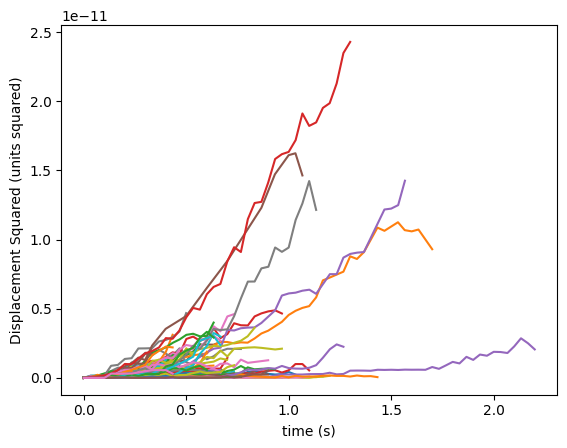

In [333]:
data_onion4.plot_displacementAll()

In [334]:
particle_trial3_visco_3 = BMC_data('SJ_trial3_visco3_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


In [335]:
particle_z6_visco_3 = BMC_data('SJ_trial3_visco3_40x.txt')
particle_z6_visco_2 = BMC_data('SJ_trial3_visco2_40x.txt')
particle_z6_visco_1 = BMC_data('SJ_trial3_visco1_40x.txt')
particle_z5_visco_1 = BMC_data('SJ_trial2_visco1_40x.txt')
particle_z5_visco_2 = BMC_data('SJ_trial2_visco2_40x.txt')
particle_z5_visco_3 = BMC_data('SJ_trial2_visco3_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.r

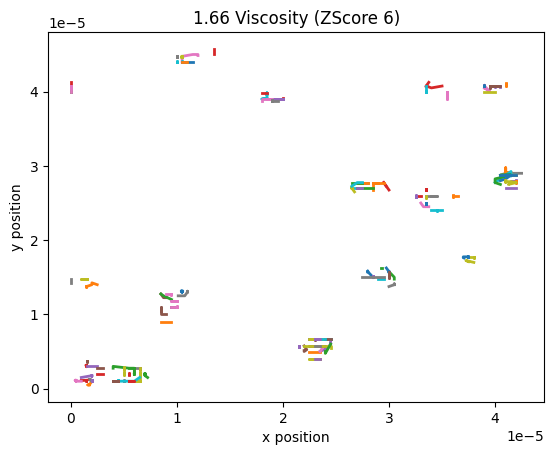

In [336]:
particle_z6_visco_1.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='1.66 Viscosity (ZScore 6)')

In [337]:
particle_z6_visco_1.compute_diffusionAll()

np.float64(6.24218932309846e-14)

In [355]:
particleData = particle_z6_visco_1.pull_particle(whichParticle=particle)
time =  np.sum(particleData['dt'])
print(time)

1.0331033


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/3829465433.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/3829465433.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


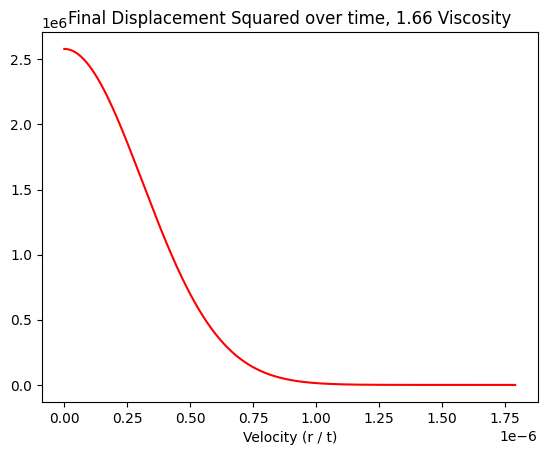

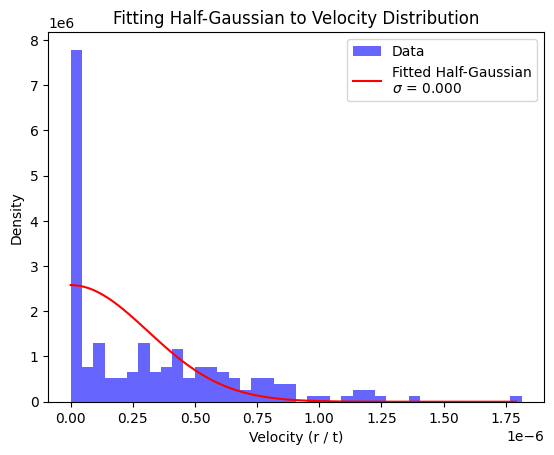

3.093652087103498e-07


In [347]:
# Get histogram data (frequency and bin edges)
def half_gaussian(x, sigma):
    return (np.sqrt(2) / (sigma * np.sqrt(np.pi))) * np.exp(-x**2 / (2 * sigma**2)) * (x >= 0)

# Fit the histogram data to the Half-Gaussian function
#plt.hist(particle_z6_visco_1.get_avg_speed(),bins = 40)
plt.title('Final Displacement Squared over time, 1.66 Viscosity')
hist, bin_edges = np.histogram(particle_z6_visco_1.get_avg_speed()*(, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]


plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.show()
plt.hist(particle_z6_visco_1.get_avg_speed(), bins=40, density=True, alpha=0.6, color='b', label='Data')  # Plot the histogram
x_vals = np.linspace(0, np.max(bin_centers), 1000)  # Generate x-values for plotting the fit
fitted_curve = half_gaussian(x_vals, sigma)  # Compute the fitted curve

# Plot the fitted curve
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.show()
print(sigma)

[0.00000000e+00 0.00000000e+00 2.50000000e-13 3.90625000e-13
 2.00000000e-12 2.50000000e-13 0.00000000e+00 3.12500000e-13
 0.00000000e+00 1.14795918e-14 1.11849712e-15 1.00000000e-12
 3.12500000e-13 2.50000000e-13 1.00000000e-12 5.00000000e-13
 0.00000000e+00 0.00000000e+00 2.50000000e-13 0.00000000e+00
 0.00000000e+00 1.00000000e-12 0.00000000e+00 3.12500000e-13
 4.00000000e-12 0.00000000e+00 3.12500000e-13 0.00000000e+00
 0.00000000e+00 2.50000000e-13 0.00000000e+00 0.00000000e+00
 1.56250000e-12 0.00000000e+00 1.00000000e-12 0.00000000e+00
 2.50179615e-13 2.50000000e-13 2.50000000e-13 2.50000000e-13
 0.00000000e+00 1.00000000e-12 0.00000000e+00 1.25000000e-12
 6.25000000e-14 0.00000000e+00 2.50000000e-13 4.06250000e-12
 1.00000000e-12 0.00000000e+00 0.00000000e+00 2.61971249e-13
 1.25000000e-12 0.00000000e+00 1.56250000e-14 0.00000000e+00
 1.29132231e-14 9.98589803e-13 0.00000000e+00 0.00000000e+00
 1.23456790e-14 2.50000000e-13 0.00000000e+00 3.90625000e-13
 1.56250000e-14 2.500000

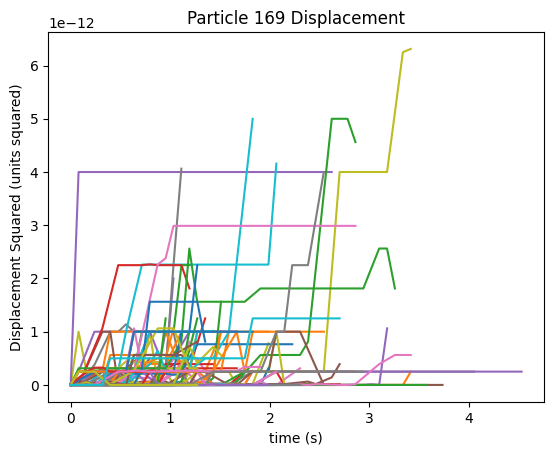

In [396]:
#def plot_displacementSingle(self,whichParticle,xLabel='time (s)',yLabel='Displacement Squared (units squared)',plotTitle=''):
# for particle_id in range(particle_z6_visco_1.particleNumber):
#     particle_data = particle_z6_visco_1.pull_particle(particle_id)
#     particle_data.plot_displacementSingle(whichParticle=pid,
#                                                  xLabel='time (s)',
#                                                  yLabel='Displacement Squared (units squared)',
#                                                  plotTitle=f'Particle {pid} Displacement')

for particle_id in range(particle_z6_visco_1.particleNumber):
    particle_z6_visco_1.plot_displacementSingle(
        whichParticle=particle_id,
        xLabel='time (s)',
        yLabel='Displacement Squared (units squared)',
        plotTitle=f'Particle {particle_id} Displacement'
    )

final_displacements_squared = []
for particle_id in range(particle_z6_visco_1.particleNumber):
    particle_data = particle_z6_visco_1.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(particle_z6_visco_1.particleNumber):
    particle_data = particle_z6_visco_1.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

(array([5525382.98563664, 1311107.82710022,   93650.55907859,
          93650.55907859,   93650.55907859,       0.        ,
              0.        , 2903167.3314362 , 1311107.82710022,
         468252.79539294,       0.        ,  374602.23631435,
              0.        ,   93650.55907859,  374602.23631435,
        1311107.82710022,  280951.67723576,  374602.23631435,
              0.        ,   93650.55907859,       0.        ,
         187301.11815717,   93650.55907859,  187301.11815717,
              0.        ,       0.        ,       0.        ,
          93650.55907859,       0.        ,       0.        ,
              0.        ,  187301.11815717,  187301.11815717,
              0.        ,   93650.55907859,   93650.55907859,
              0.        ,       0.        ,       0.        ,
          93650.55907859]),
 array([0.00000000e+00, 6.28117226e-08, 1.25623445e-07, 1.88435168e-07,
        2.51246891e-07, 3.14058613e-07, 3.76870336e-07, 4.39682058e-07,
        5.02493781e-07

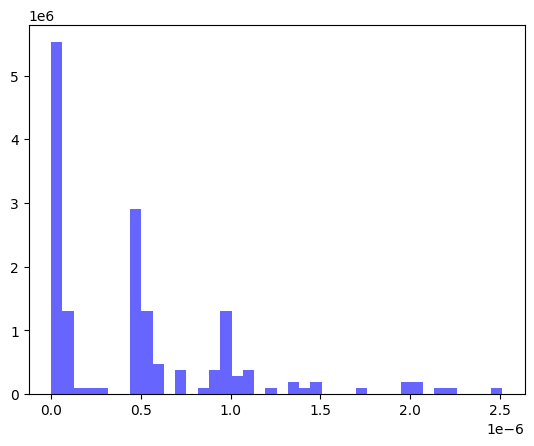

In [384]:
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')


<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4217448638.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


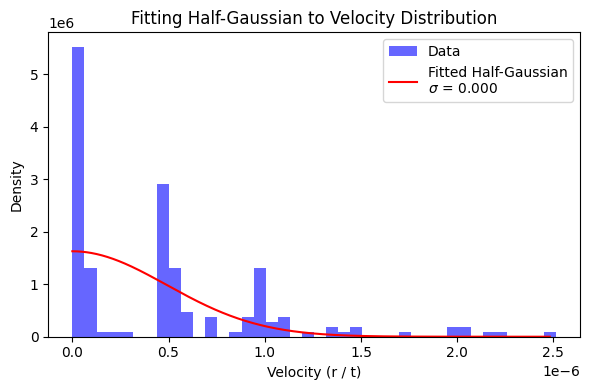

Fitted sigma: 4.898304550000505e-07


In [390]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Half-Gaussian function
def half_gaussian(x, sigma):
    return (np.sqrt(2) / (sigma * np.sqrt(np.pi))) * np.exp(-x**2 / (2 * sigma**2)) * (x >= 0)


# Histogram of data
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)


In [460]:
#Sigma = 4.898304550000505e-07
#Average_time = 1.6216327352941173 s
DC_second_way = (4.898304550000505e-07**(2))/(4*1.6216327352941173)
print(DC_second_way)
print(particle_z6_visco_1.compute_diffusionAll())

3.6989552169166e-14
6.24218932309846e-14


In [407]:
# Error propagation 
std_dev = np.std(times_1, ddof=1)  # use ddof=1 for sample standard deviation
sem = std_dev / np.sqrt(len(times_1)) # = 0.05541544483023275
3.6989552169166e-14* np.sqrt((0.05541544483023275 / 1.6216327352941173)**2) #= np.float64(1.2640300376975688e-15)
print(f"Relative error: {1.2640300376975688e-15/3.6989552169166e-14*100}")

Relative error: 3.41726234455806


In [321]:
for particle in np.arange(particle_z6_visco_1.particleNumber):
    print(Displacement)

NameError: name 'Displacement' is not defined

In [408]:
# from scipy.stats import norm
# from scipy.optimize import curve_fit

# plt.hist(particle_z6_visco_1.get_avg_speed(),bins = 40)
# plt.title('Final Displacement Squared over time, 1.66 Viscosity')
# print(particle_z6_visco_1.compute_diffusionAll())
# # from scipy import stats
# # from scipy.stats import gaussian_kde
# kde = gaussian_kde(particle_z6_visco_1.get_avg_speed(), bw_method=1.0)

# # # Define grid to evaluate KDE
# x_grid = np.linspace(min(particle_z6_visco_1.get_avg_speed()), max(particle_z6_visco_1.get_avg_speed()),170)
# print(np.std(particle_z6_visco_1.get_avg_speed()))
# # # Plot the KDE
# # plt.plot(x_grid, norm.pdf(x_grid, loc=3.194502142408537e-07, scale = 3.5351378520437985e-07))
# def half_gaussian(x, A, sigma):
#     return A * np.exp(-x**2 / (2 * sigma**2))

# # Fit
# popt, _ = curve_fit(half_gaussian, x_grid,particle_z6_visco_1.get_avg_speed(), p0=[60, .0005])
# plt.plot(x_grid, half_gaussian(x_grid, *popt), color='red', label='Fit')



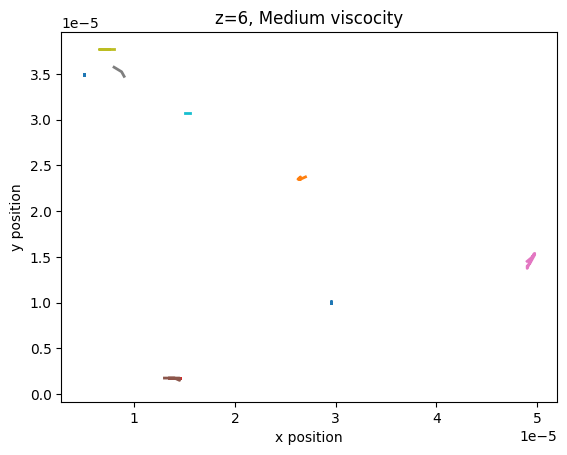

In [80]:
particle_z6_visco_2.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=6, Medium viscocity')

4.28417369167292e-14


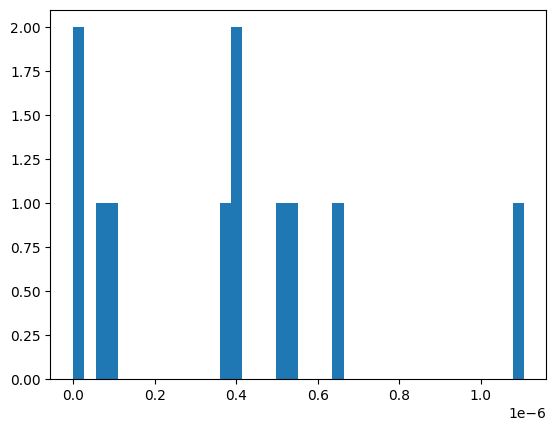

In [409]:
plt.hist(particle_z6_visco_2.get_avg_speed(), bins = 40)
print(particle_z6_visco_2.compute_diffusionAll())

1.8903135029218858e-13


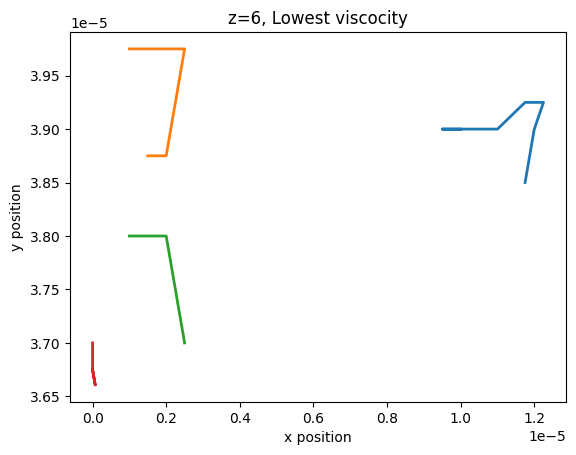

In [190]:
particle_z6_visco_3.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=6, Lowest viscocity')
print(particle_z6_visco_3.compute_diffusionAll())

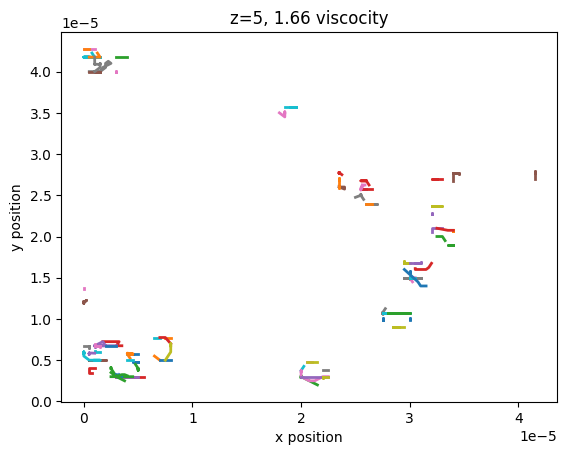

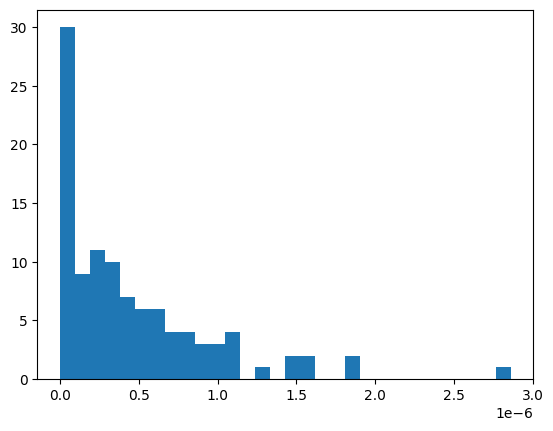

ValueError: operands could not be broadcast together with shapes (3,) (105,) 

In [249]:
particle_z5_visco_1.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=5, 1.66 viscocity')
plt.show()
plt.hist(particle_z5_visco_1.get_avg_speed(), bins = 30)
plt.show()
x_grid_1 = (min(particle_z5_visco_1.get_avg_speed()), max(particle_z5_visco_1.get_avg_speed()),105)
def half_gaussian(x, A, sigma):
    return A * np.exp(-x**2 / (2 * sigma**2))

# Fit
popt, _ = curve_fit(half_gaussian, x_grid_1, particle_z5_visco_1.get_avg_speed(), p0=[60, .0005])
plt.plot(x_grid_1, half_gaussian(x_grid_1, *popt), color='red', label='Fit')


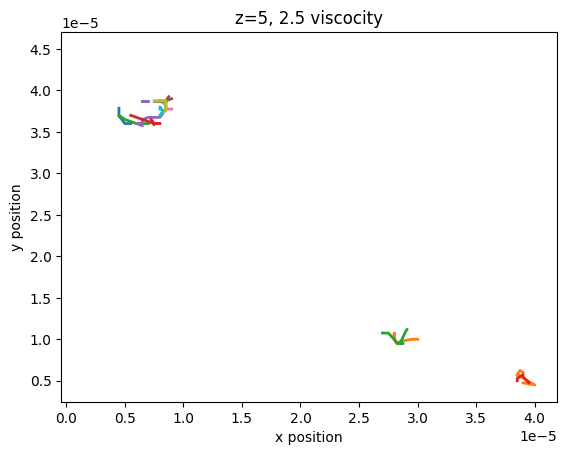

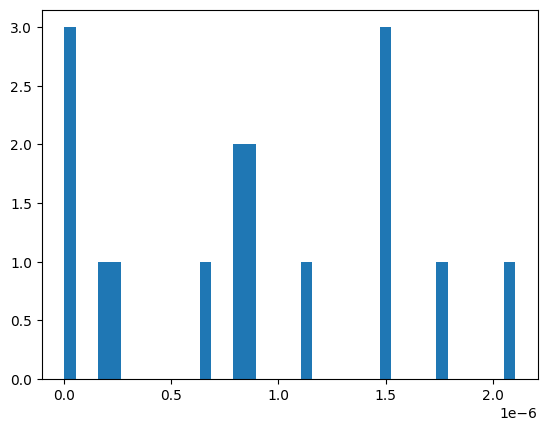

In [210]:
particle_z5_visco_2.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=5, 2.5 viscocity')
plt.show()
plt.hist(particle_z5_visco_2.get_avg_speed(), bins = 40)
plt.show()


In [84]:
bigparticle_z6 = BMC_data('SJ_bigparticle_3_40x.txt')
bigparticle_z5 = BMC_data('SJ_bigparticle_2_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


In [ ]:
particle_z6_visco_1.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='1.66 Viscosity (ZScore 6)')

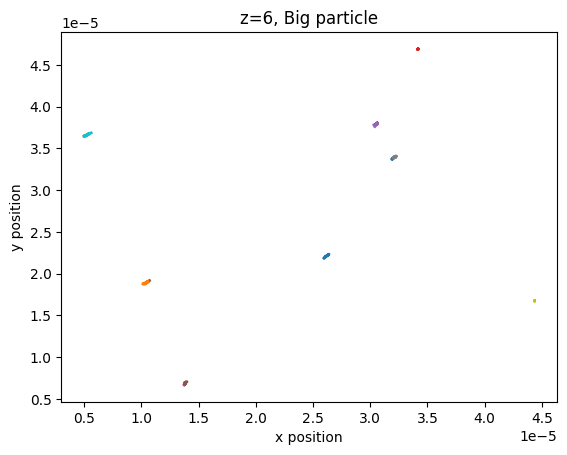

In [85]:
bigparticle_z6.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=6, Big particle')

(array([2., 0., 1., 2., 0., 1., 0., 2., 1., 0., 0., 1., 0., 1., 3., 0., 1.,
        0., 0., 1.]),
 array([1.21657296e-08, 2.58186698e-08, 3.94716100e-08, 5.31245502e-08,
        6.67774904e-08, 8.04304306e-08, 9.40833708e-08, 1.07736311e-07,
        1.21389251e-07, 1.35042191e-07, 1.48695132e-07, 1.62348072e-07,
        1.76001012e-07, 1.89653952e-07, 2.03306893e-07, 2.16959833e-07,
        2.30612773e-07, 2.44265713e-07, 2.57918653e-07, 2.71571594e-07,
        2.85224534e-07]),
 <BarContainer object of 20 artists>)

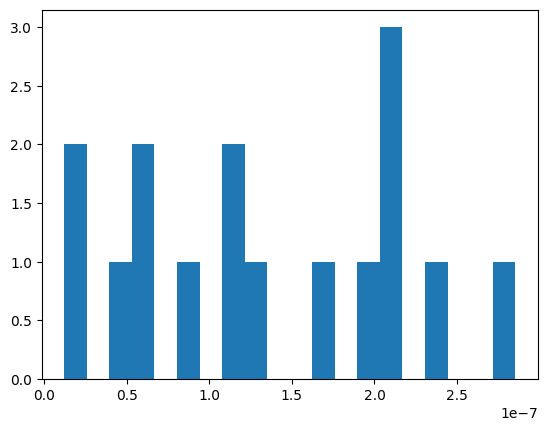

In [86]:
plt.hist(bigparticle_z6.get_avg_speed(), bins = 20)

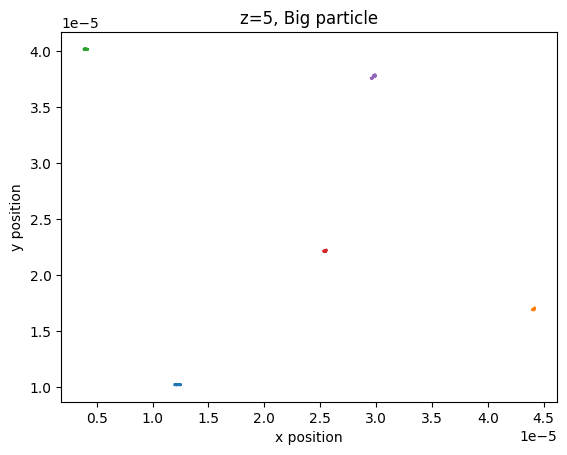

In [87]:
bigparticle_z5.plot_trajectories(xLabel='x position',yLabel='y position',plotTitle='z=5, Big particle')

(array([2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2.]),
 array([2.90893139e-09, 7.19668188e-09, 1.14844324e-08, 1.57721829e-08,
        2.00599334e-08, 2.43476839e-08, 2.86354343e-08, 3.29231848e-08,
        3.72109353e-08, 4.14986858e-08, 4.57864363e-08, 5.00741868e-08,
        5.43619373e-08, 5.86496878e-08, 6.29374383e-08, 6.72251888e-08,
        7.15129393e-08, 7.58006898e-08, 8.00884403e-08, 8.43761908e-08,
        8.86639412e-08]),
 <BarContainer object of 20 artists>)

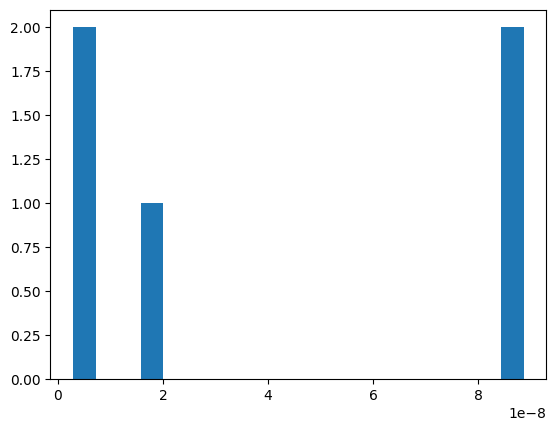

In [88]:
plt.hist(bigparticle_z5.get_avg_speed(), bins = 20)

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


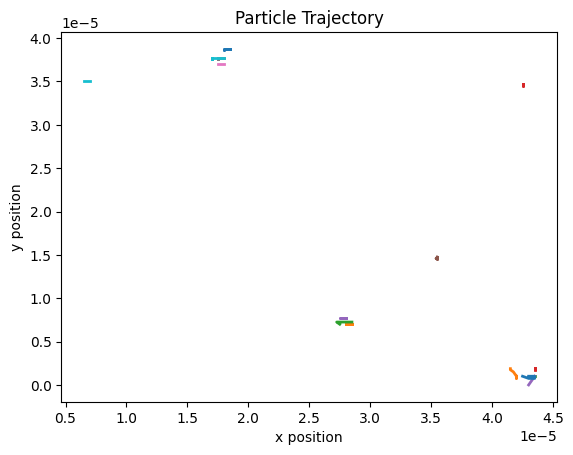

In [89]:
particle_trial4_visco_2= BMC_data('SJ_trial1_visco2_40x.txt')
particle_trial4_visco_2.plot_trajectories()

In [446]:
particle_trial1_visco_2= BMC_data('SJ_trial1_visco2_40x.txt') #** Zscore 7
particle_trial2_visco_2= BMC_data('SJ_trial2_visco2_40x.txt')
particle_trial3_visco_2= BMC_data('SJ_trial3_visco2_40x.txt')
particle_trial5_visco_2= BMC_data('SJ_trial5_visco2_40x.txt')
particle_trial0_visco_2= BMC_data('SJ_trial0_visco2_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.r

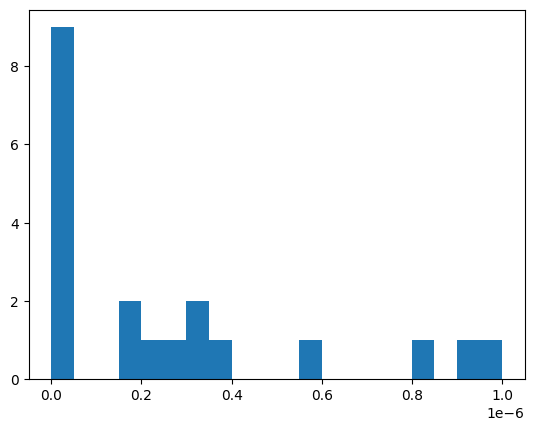

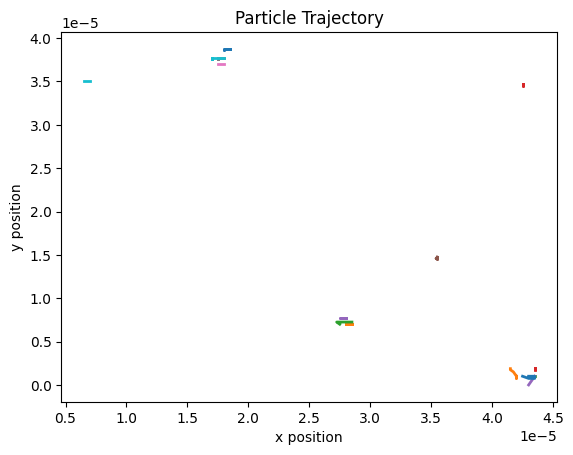

4.442648937054118e-14


In [459]:
plt.hist(particle_trial1_visco_2.get_avg_speed(),bins = 20)
plt.show()
particle_trial1_visco_2.plot_trajectories()
plt.show()
print(particle_trial1_visco_2.compute_diffusionAll())

In [461]:
final_displacements_squared = []
for particle_id in range(particle_trial1_visco_2.particleNumber):
    particle_data = particle_trial1_visco_2.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(particle_trial1_visco_2.particleNumber):
    particle_data = particle_trial1_visco_2.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

[0.00000000e+00 1.01562500e-12 2.50000000e-13 6.25000000e-14
 1.25000000e-12 2.64889633e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50000000e-13 2.50000000e-13 0.00000000e+00
 1.06250000e-12 0.00000000e+00 0.00000000e+00 6.05458985e-17
 2.50000000e-13 2.50000000e-13 0.00000000e+00 1.01562500e-12]
[1.2791279 2.6382638 1.4391439 1.4391439 1.1191119 1.0391039 1.7581758
 1.5191519 0.8790879 2.0792079 0.8790879 1.5191519 1.2781278 1.0391039
 1.6791679 1.3591359 1.8381838 1.5181518 1.5991599 1.1191119]
1.450895075


(array([16099689.43799848,        0.        ,        0.        ,
               0.        ,        0.        ,  1788854.38199983,
               0.        ,        0.        ,  1788854.38199983,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,  8944271.90999916,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
         5366563.1459995 ,        0.        ,        0.        ,
         1788854.38199983]),
 array([0.00000000e+00, 2.79508497e-08, 5.59016994e-08, 8.38525492e-08,
        1.11803399e-07, 1.39754249e-07, 1.67705098e-07

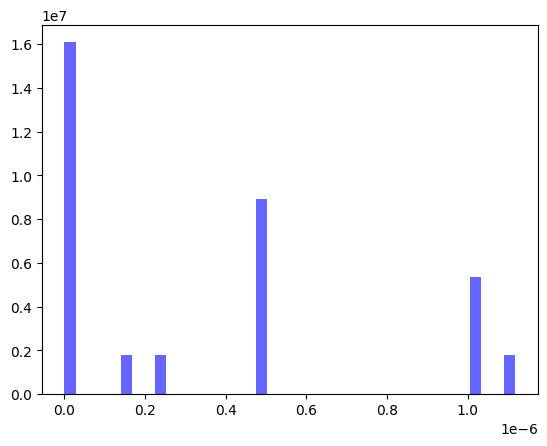

In [463]:
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/2649214652.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


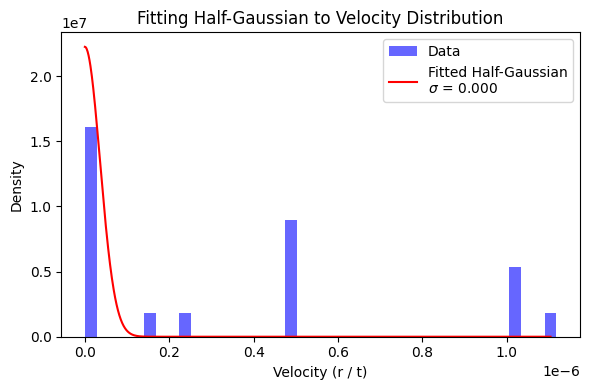

Fitted sigma: 3.5843235747479105e-08


In [464]:
# Histogram of data
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)


In [465]:
#Sigma = 3.5843235747479105e-08
#Average_time = 1.450895075 s
DC_second_way = ( 3.5843235747479105e-08**(2))/(4*1.450895075)
print(DC_second_way)

2.2136982387395657e-16


In [468]:
std_dev = np.std(times_1, ddof=1)  # use ddof=1 for sample standard deviation
sem = std_dev / np.sqrt(len(times_1)) # =0.09484401733102896

print(sem)
print(2.2136982387395657e-16* np.sqrt((0.09484401733102896 / 1.450895075)**2)) #= np.float64(1.2640300376975688e-15)
print(f"Relative error: {1.4470793769886058e-17/2.2136982387395657e-16*100}") #= 1.6370218864590163 %

0.09484401733102896
1.4470793769886058e-17
Relative error: 6.536931509746076


(array([2., 2., 0., 0., 0., 0., 1., 2., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([0.00000000e+00, 5.52803814e-08, 1.10560763e-07, 1.65841144e-07,
        2.21121525e-07, 2.76401907e-07, 3.31682288e-07, 3.86962670e-07,
        4.42243051e-07, 4.97523432e-07, 5.52803814e-07, 6.08084195e-07,
        6.63364576e-07, 7.18644958e-07, 7.73925339e-07, 8.29205720e-07,
        8.84486102e-07, 9.39766483e-07, 9.95046864e-07, 1.05032725e-06,
        1.10560763e-06]),
 <BarContainer object of 20 artists>)

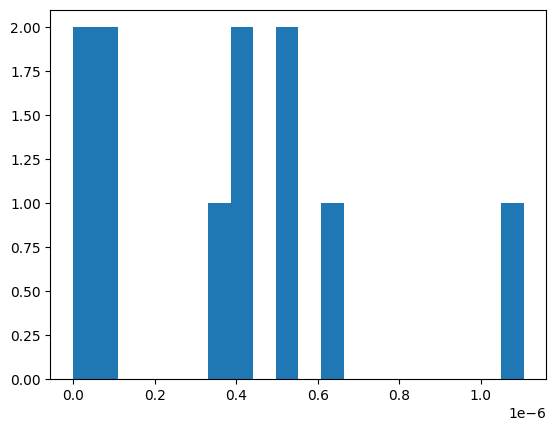

In [452]:
plt.hist(particle_trial4_visco_2.get_avg_speed(), bins = 20)

In [194]:
print("Diffusion Coeff:", data_onion4.compute_diffusionAll())

Diffusion Coeff: 4.215461564321538e-13


/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


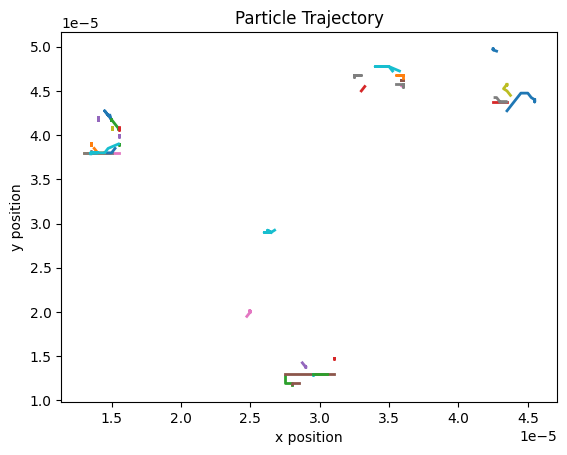

In [95]:
PVP_z6= BMC_data('SJ_PVP_visco2_trial_3_40x.txt')
PVP_z6.plot_trajectories()

In [96]:
visco3_z7_question = BMC_data('SJtrial_4visco_3_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


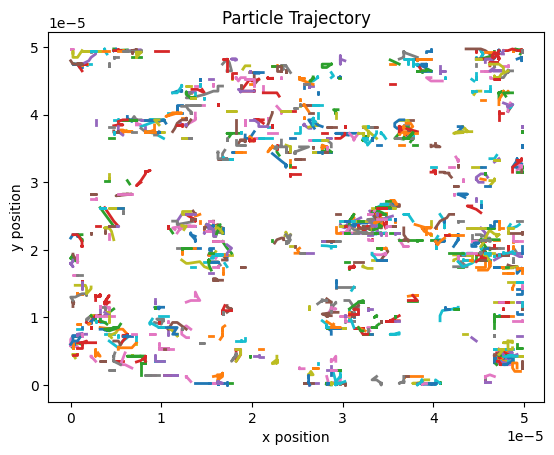

In [97]:
visco3_z7_question.plot_trajectories()

(array([297.,  54.,  47.,  64.,  91., 103.,  99.,  58.,  47.,  48.,  47.,
         46.,  29.,  26.,  26.,  23.,  12.,   8.,   2.,  10.,   8.,   4.,
          3.,   4.,   0.,   4.,   0.,   2.,   2.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   2.]),
 array([0.00000000e+00, 7.82262189e-08, 1.56452438e-07, 2.34678657e-07,
        3.12904876e-07, 3.91131094e-07, 4.69357313e-07, 5.47583532e-07,
        6.25809751e-07, 7.04035970e-07, 7.82262189e-07, 8.60488408e-07,
        9.38714627e-07, 1.01694085e-06, 1.09516706e-06, 1.17339328e-06,
        1.25161950e-06, 1.32984572e-06, 1.40807194e-06, 1.48629816e-06,
        1.56452438e-06, 1.64275060e-06, 1.72097682e-06, 1.79920303e-06,
        1.87742925e-06, 1.95565547e-06, 2.03388169e-06, 2.11210791e-06,
        2.19033413e-06, 2.26856035e-06, 2.34678657e-06, 2.42501279e-06,
        2.50323900e-06, 2.58146522e-06, 2.65969144e-06, 2.73791766e-06,
        2.81614388e-06, 2.89437010e-06, 2.97259632e-06, 3.05082254e-06,
      

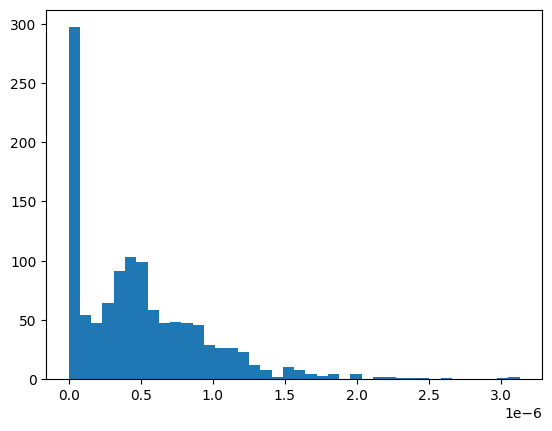

In [98]:
plt.hist(visco3_z7_question.get_avg_speed(), bins = 40)

In [163]:
visco1_z8_question = BMC_data('SJtrial_4visco_1_40x.txt')
visco1_z6_question = BMC_data('SJtrial_8visco_1_40x.txt')
visco1_z7_question = BMC_data('SJtrial_9visco_1_40x.txt')
visco2_z6_question = BMC_data('SJtrial_2visco_2_40x.txt')
visco2_z7_question = BMC_data('SJtrial_3visco_2_40x.txt')
visco3_z5_question = BMC_data('SJtrial_2visco_3_40x.txt')
visco3_z6_question = BMC_data('SJtrial_3visco_3_40x.txt')
visco3_z7_question = BMC_data('SJtrial_4visco_3_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4002154815.py:157: FutureWarning: The 'delim_whitespace' keyword in pd.r

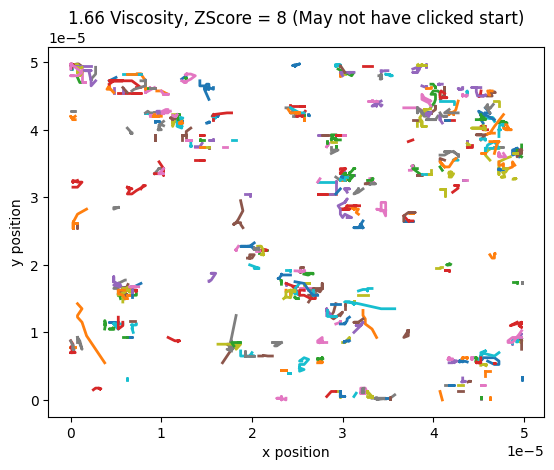

In [100]:
visco1_z8_question.plot_trajectories(plotTitle = ('1.66 Viscosity, ZScore = 8 (May not have clicked start)'))

Text(0.5, 1.0, '1.66 Viscosity, ZScore = 8 (May not have clicked start)')

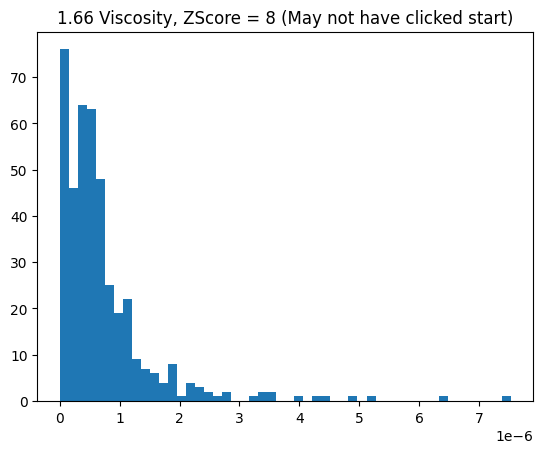

In [411]:
plt.hist(visco1_z8_question.get_avg_speed(), bins = 50)
plt.title('1.66 Viscosity, ZScore = 8 (May not have clicked start)')

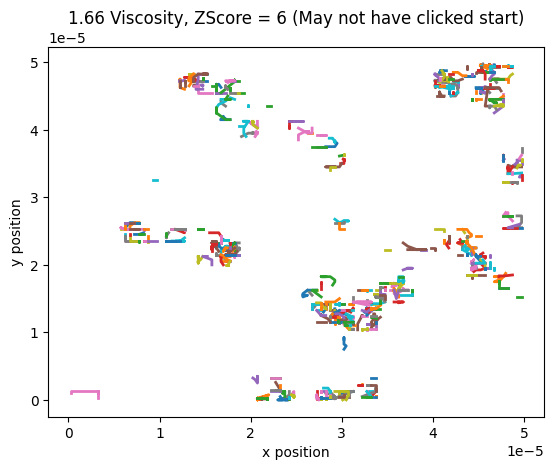

In [102]:
visco1_z6_question.plot_trajectories(plotTitle = ('1.66 Viscosity, ZScore = 6 (May not have clicked start)'))

Text(0.5, 1.0, '1.66 Viscosity, ZScore = 6 (May not have clicked start)')

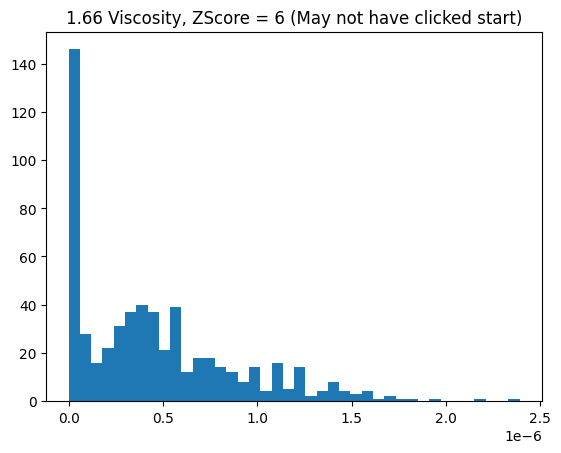

In [103]:
plt.hist(visco1_z6_question.get_avg_speed(), bins = 40)
plt.title('1.66 Viscosity, ZScore = 6 (May not have clicked start)')

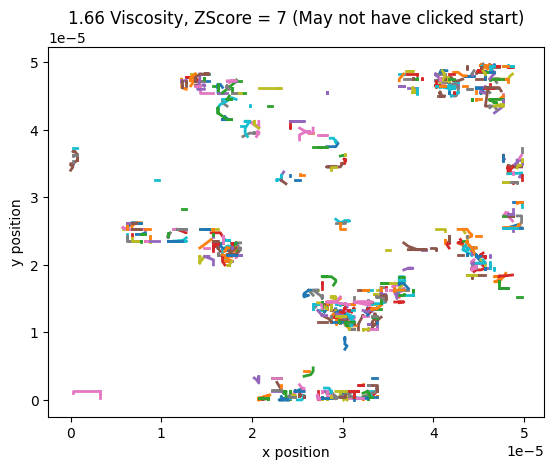

In [104]:
visco1_z7_question.plot_trajectories(plotTitle = ('1.66 Viscosity, ZScore = 7 (May not have clicked start)'))

Text(0.5, 1.0, '1.66 Viscosity, ZScore = 7 (May not have clicked start)')

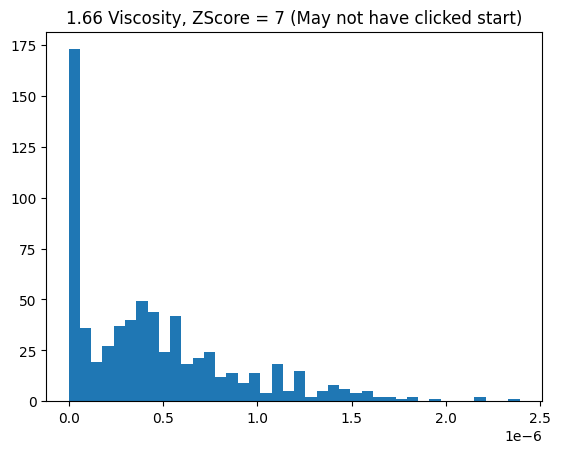

In [171]:
plt.hist(visco1_z7_question.get_avg_speed(), bins = 40)
plt.title('1.66 Viscosity, ZScore = 7 (May not have clicked start)')

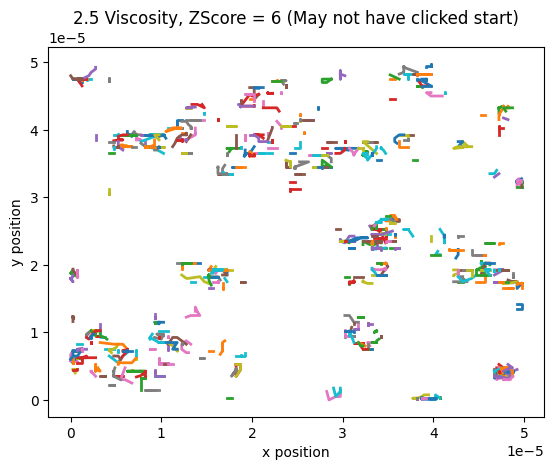

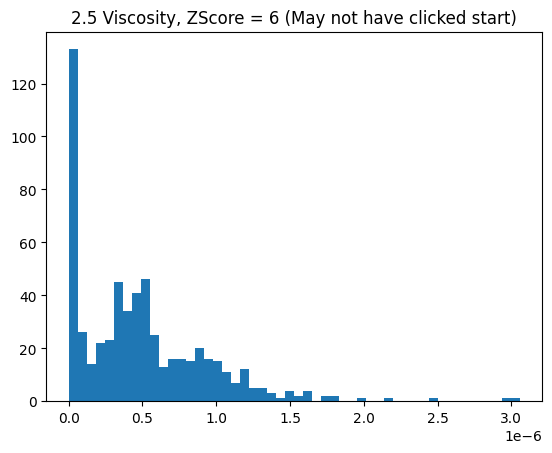

1.1350994880147589e-13


In [196]:
visco2_z6_question.plot_trajectories(plotTitle = ('2.5 Viscosity, ZScore = 6 (May not have clicked start)'))
plt.show()
plt.hist(visco2_z6_question.get_avg_speed(), bins = 50)
plt.title('2.5 Viscosity, ZScore = 6 (May not have clicked start)')
plt.show()
print(visco2_z6_question.compute_diffusionAll())

In [502]:
final_displacements_squared = []
for particle_id in range(visco2_z6_question.particleNumber):
    particle_data = visco2_z6_question.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(visco2_z6_question.particleNumber):
    particle_data = visco2_z6_question.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

[1.70117227e-13 2.50000000e-13 3.12500000e-13 3.90625000e-13
 3.12500000e-13 0.00000000e+00 0.00000000e+00 6.25000000e-13
 3.12500000e-13 1.00000000e-12 2.50000000e-13 1.56250000e-14
 0.00000000e+00 2.65625000e-13 2.50000000e-13 0.00000000e+00
 0.00000000e+00 2.50000000e-13 2.50000000e-13 2.50000000e-13
 0.00000000e+00 0.00000000e+00 1.81250000e-12 1.00000000e-12
 0.00000000e+00 9.98890533e-13 1.56250000e-14 1.15310121e-14
 2.50000000e-13 2.25000000e-12 0.00000000e+00 0.00000000e+00
 6.40625000e-13 1.25000000e-12 5.31250000e-12 8.12500000e-13
 8.12500000e-13 1.81250000e-12 5.62500000e-13 2.25000000e-12
 1.00000000e-12 5.62500000e-13 0.00000000e+00 1.56250000e-14
 5.00000000e-13 4.00000000e-12 0.00000000e+00 4.43213296e-14
 2.64756944e-14 0.00000000e+00 1.25000000e-12 7.81250000e-14
 2.50000000e-13 2.50000000e-13 0.00000000e+00 3.12500000e-13
 6.77211859e-13 2.50000000e-13 1.05625000e-11 8.12500000e-13
 2.25000000e-12 1.00000000e-12 2.62913223e-13 0.00000000e+00
 2.67712887e-13 0.000000

(array([2702203.45692044,  717772.79324449,  168887.71605753,
         232220.6095791 ,  168887.71605753,   21110.96450719,
        3187755.64058583,  189998.68056472,  253331.57408629,
         569996.04169415,   63332.89352157,  464441.2191582 ,
        1224435.94141707,  422219.29014382,   21110.96450719,
         232220.6095791 ,  147776.75155034,  232220.6095791 ,
         295553.50310067,   84443.85802876,   63332.89352157,
         105554.82253595,  168887.71605753,   21110.96450719,
         253331.57408629,   42221.92901438,   42221.92901438,
          63332.89352157,   42221.92901438,   42221.92901438,
              0.        ,       0.        ,       0.        ,
          21110.96450719,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
          42221.92901438]),
 array([0.00000e+00, 8.12500e-08, 1.62500e-07, 2.43750e-07, 3.25000e-07,
        4.06250e-07, 4.87500e-07, 5.68750e-07, 6.50000e-07, 7.31250e-07,
        8.12500e-07,

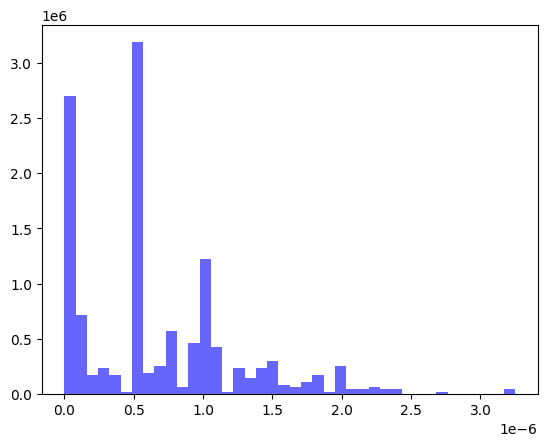

In [503]:
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/4217448638.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


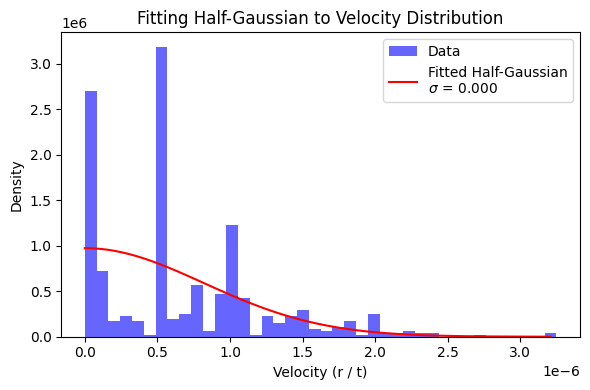

Fitted sigma: 8.190776868451529e-07


In [504]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Half-Gaussian function
def half_gaussian(x, sigma):
    return (np.sqrt(2) / (sigma * np.sqrt(np.pi))) * np.exp(-x**2 / (2 * sigma**2)) * (x >= 0)


# Histogram of data
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)


In [507]:
#Sigma = 8.190776868451529e-07
#Average_time = 1.4707594111492281
DC_second_way = (8.190776868451529e-07**(2))/(4*1.4707594111492281)
print(DC_second_way)
print(visco2_z6_question.compute_diffusionAll())

1.1403772976087655e-13
1.1350994880147589e-13


In [506]:
# Error propagation 
std_dev = np.std(times_1, ddof=1)  # use ddof=1 for sample standard deviation
sem = std_dev / np.sqrt(len(times_1)) # =0.024076653457668615

print(sem)
print(1.2385975056109454e-13* np.sqrt((0.024076653457668615 / 1.4707594111492281)**2)) #= np.float64(1.2640300376975688e-15)
print(f"Relative error: {2.027611225198662e-15/1.2385975056109454e-13*100}") #= 1.6370218864590163 %

0.024076653457668615
2.027611225198662e-15
Relative error: 1.6370218864590163


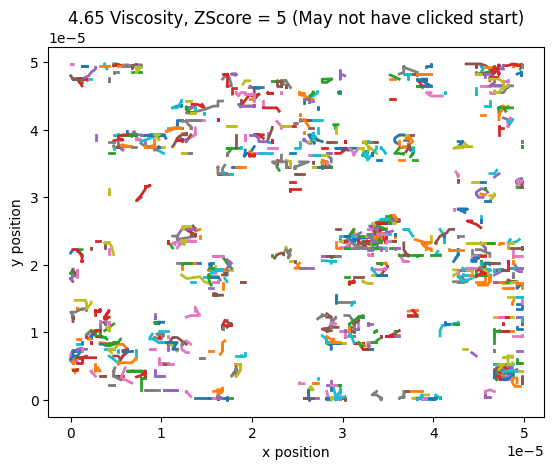

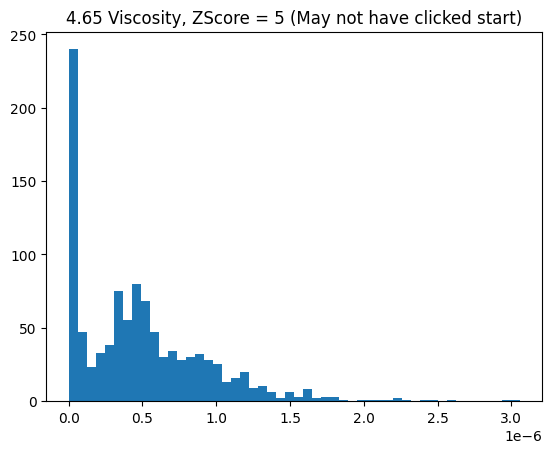

1.148506557372189e-13


In [427]:
visco3_z5_question.plot_trajectories(plotTitle = ('4.65 Viscosity, ZScore = 5 (May not have clicked start)'))
plt.show()
plt.hist(visco3_z5_question.get_avg_speed(), bins = 50)
plt.title('4.65 Viscosity, ZScore = 5 (May not have clicked start)')
plt.show()
print(visco3_z5_question.compute_diffusionAll())

In [508]:
final_displacements_squared = []
for particle_id in range(visco3_z5_question.particleNumber):
    particle_data = visco3_z5_question.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(visco3_z5_question.particleNumber):
    particle_data = visco3_z5_question.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

[1.70117227e-13 2.50000000e-13 3.12500000e-13 ... 2.25000000e-12
 8.00000000e-12 1.00000000e-12]
[1.3971397 1.0871087 1.630163  ... 1.0021002 1.0791079 1.1561156]
1.4570648740019474


(array([2493087.54820211,  641996.79352844,  256798.71741138,
         106999.46558807,   74899.62591165, 2289788.56358477,
         609896.95385202,  246098.77085257,  481497.59514633,
         492197.54170514, 1005794.97652789,  331698.34332303,
         406597.96923468,  106999.46558807,  149799.2518233 ,
         181899.09149972,  278198.61052899,   42799.78623523,
          64199.67935284,  160499.19838211,   96299.51902927,
         117699.41214688,  128399.35870569,   21399.89311761,
          42799.78623523,   32099.83967642,   21399.89311761,
          10699.94655881,       0.        ,   10699.94655881,
          10699.94655881,   21399.89311761,   10699.94655881,
              0.        ,       0.        ,   21399.89311761,
          10699.94655881,       0.        ,       0.        ,
          10699.94655881]),
 array([0.00000000e+00, 9.10013736e-08, 1.82002747e-07, 2.73004121e-07,
        3.64005494e-07, 4.55006868e-07, 5.46008242e-07, 6.37009615e-07,
        7.28010989e-07

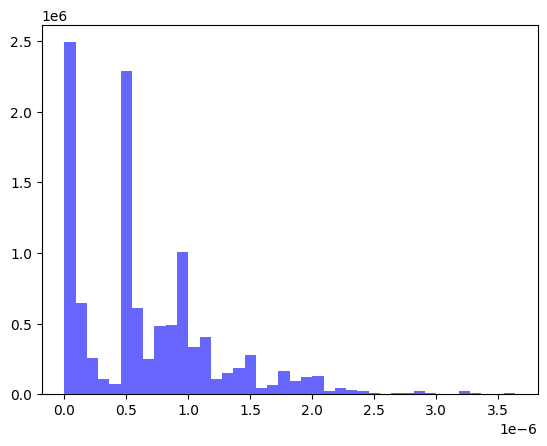

In [429]:
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/3953852910.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


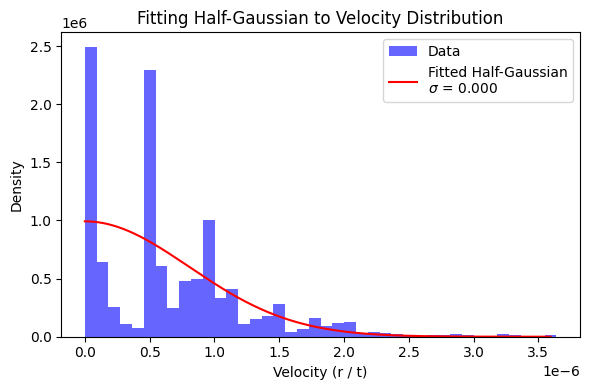

Fitted sigma: 8.039706817783131e-07


In [430]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Half-Gaussian function
def half_gaussian(x, sigma):
    return (np.sqrt(2) / (sigma * np.sqrt(np.pi))) * np.exp(-x**2 / (2 * sigma**2)) * (x >= 0)


# Histogram of data
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)

In [431]:
#Sigma = 8.039706817783131e-07
#Average_time = 1.4570648740019474 s
DC_second_way = (8.039706817783131e-07**(2))/(4*1.4570648740019474)
print(DC_second_way)

1.1090255291512532e-13


In [436]:
# Error propagation 
std_dev = np.std(times_1, ddof=1)  # use ddof=1 for sample standard deviation
sem = std_dev / np.sqrt(len(times_1)) # = 0.018164975501752837

print(sem)
print(1.1090255291512532e-13* np.sqrt((0.018164975501752837 / 1.4570648740019474)**2)) #= np.float64(1.382602925051645e-15)
print(f"Relative error: {1.382602925051645e-15/1.1090255291512532e-13*100}") #= 1.2466826855733095 %

0.018164975501752837
1.382602925051645e-15
Relative error: 1.2466826855733095


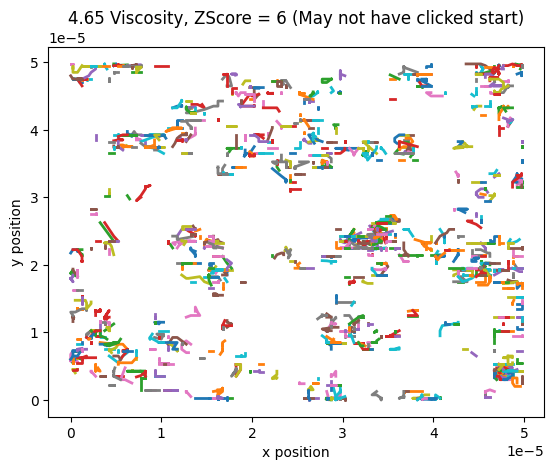

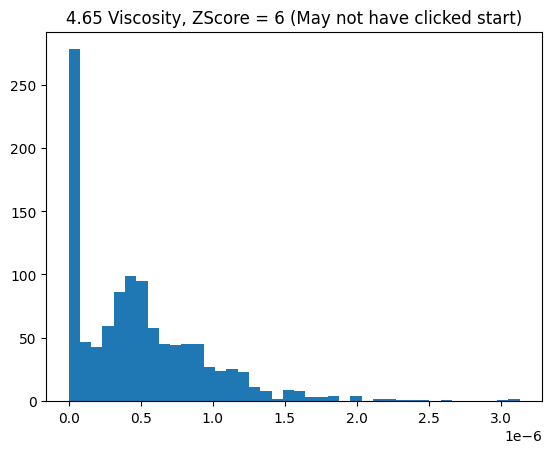

1.1415825529917827e-13
None


In [198]:
# SAME ASE : visco3_z7_question
visco3_z6_question.plot_trajectories(plotTitle = ('4.65 Viscosity, ZScore = 6 (May not have clicked start)'))
plt.show()
plt.hist(visco3_z6_question.get_avg_speed(), bins = 40)
plt.title('4.65 Viscosity, ZScore = 6 (May not have clicked start)')
plt.show()
print(print(visco3_z6_question.compute_diffusionAll()))

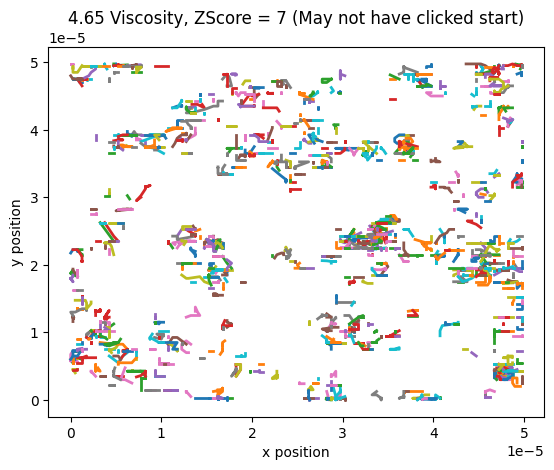

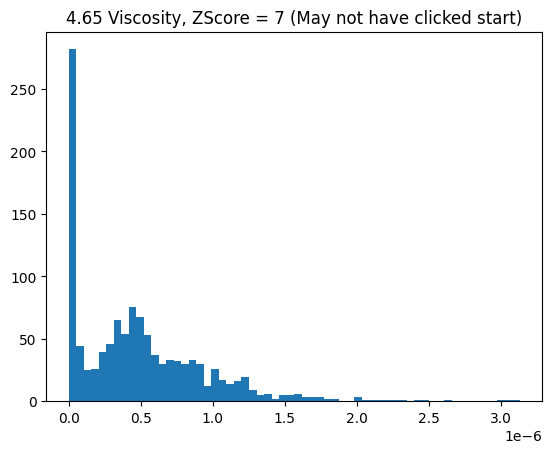

1.1319156486289479e-13


In [199]:
visco3_z7_question.plot_trajectories(plotTitle = ('4.65 Viscosity, ZScore = 7 (May not have clicked start)'))
plt.show()
plt.hist(visco3_z7_question.get_avg_speed(), bins = 60)
plt.title('4.65 Viscosity, ZScore = 7 (May not have clicked start)')
plt.show()
print(visco3_z7_question.compute_diffusionAll())

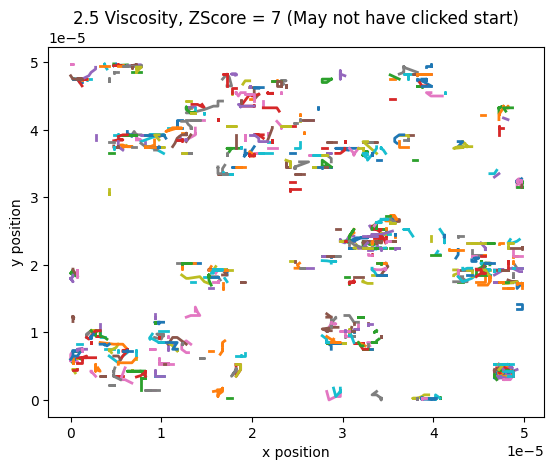

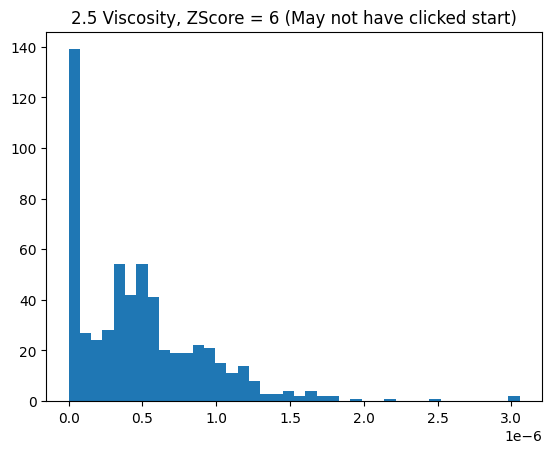

1.1307159191657981e-13
None


In [200]:
visco2_z7_question.plot_trajectories(plotTitle = ('2.5 Viscosity, ZScore = 7 (May not have clicked start)'))
plt.show()
plt.hist(visco2_z6_question.get_avg_speed(), bins = 40)
plt.title('2.5 Viscosity, ZScore = 6 (May not have clicked start)')
plt.show()
print(print(visco2_z7_question.compute_diffusionAll()))

In [492]:
PVP_1 = BMC_data('SJ_PVP_visco2_trial_1_40x.txt')
PVP_2 = BMC_data('SJ_PVP_visco2_trial_2_40x.txt')
PVP_2b = BMC_data('SJ_PVP_visco2_trial_2b_40x.txt')
PVP_2c = BMC_data('SJ_PVP_visco2_trial_2c_40x.txt')
PVP_2d = BMC_data('SJ_PVP_visco2_trial_2d_40x.txt')
PVP_3 = BMC_data('SJ_PVP_visco2_trial_3_40x.txt')
PVP_4 = BMC_data('SJ_PVP_visco2_trial_4_40x.txt')
PVP_5 = BMC_data('SJ_PVP_visco2_trial_5_40x.txt')
#plt.hist(PVP_2d.get_avg_speed(), bins = 50)
# plt.show()
# plt.hist(PVP_5.get_avg_speed(), bins = 50)
# plt.show()

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.r

np.float64(1.5622869173486232e-13)

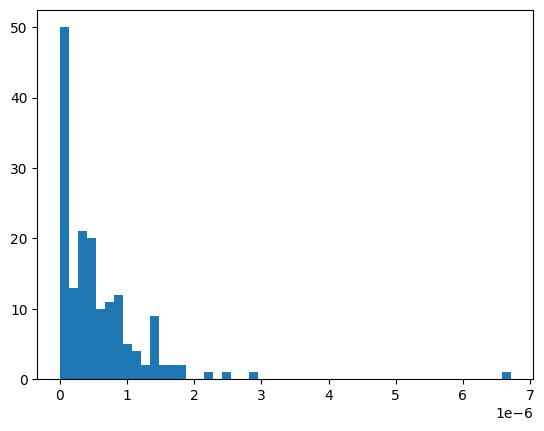

In [494]:
plt.hist(PVP_2.get_avg_speed(), bins = 50)
PVP_2.compute_diffusionAll()

In [510]:
final_displacements_squared = []
for particle_id in range(PVP_2.particleNumber):
    particle_data = PVP_2.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(PVP_2.particleNumber):
    particle_data = PVP_2.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

[4.00000000e-12 2.25000000e-12 0.00000000e+00 4.22500000e-13
 8.12500000e-13 1.00000000e-12 1.62500000e-12 2.50000000e-13
 2.25000000e-12 2.65625000e-13 2.81250000e-12 2.31250000e-12
 0.00000000e+00 6.25000000e-13 3.12500000e-13 1.06250000e-12
 0.00000000e+00 4.70864380e-13 0.00000000e+00 5.31581804e-14
 2.25000000e-12 5.62500000e-13 1.25000000e-12 1.81250000e-12
 1.00000000e-12 0.00000000e+00 3.12500000e-13 2.00000000e-12
 0.00000000e+00 2.26562500e-12 6.42500000e-11 0.00000000e+00
 2.50000000e-13 5.31250000e-12 2.50000000e-13 8.12500000e-13
 3.12500000e-13 0.00000000e+00 1.00000000e-12 1.25000000e-12
 3.12500000e-13 7.22500000e-13 6.25000000e-13 3.21384741e-12
 0.00000000e+00 1.29132231e-14 1.00000000e-12 3.31250000e-12
 6.25000000e-14 1.36680018e-14 0.00000000e+00 0.00000000e+00
 3.12500000e-13 5.62500000e-13 1.25000000e-13 0.00000000e+00
 5.00000000e-13 1.06250000e-12 1.29132231e-14 1.25000000e-12
 5.00000000e-13 2.25000000e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.500000

(array([1494090.68635163,  358581.76472439,  866572.59808395,
         388463.57845142,  507990.83335955,  268936.32354329,
          59763.62745407,  537872.64708659,  119527.25490813,
         149409.06863516,   59763.62745407,   89645.4411811 ,
          29881.81372703,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,   29881.81372703,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
          29881.81372703]),
 array([0.00000000e+00, 2.00390244e-07, 4.00780489e-07, 6.01170733e-07,
        8.01560977e-07, 1.00195122e-06, 1.20234147e-06, 1.40273171e-06,
        1.60312195e-06

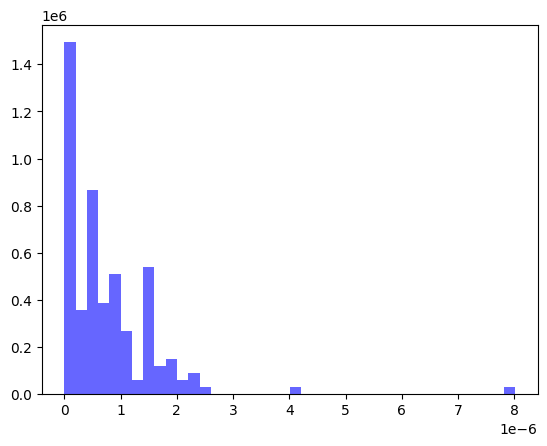

In [511]:
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/3938043358.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


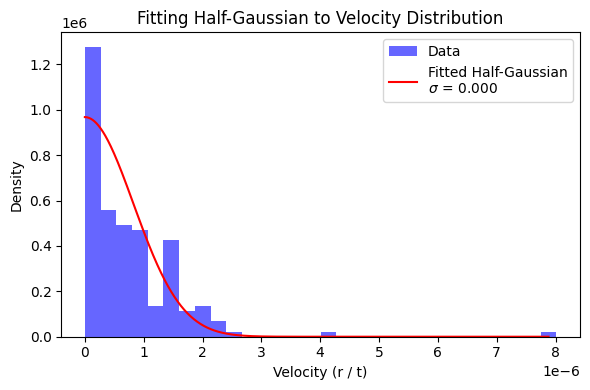

Fitted sigma: 8.244423229259441e-07


In [513]:
# Histogram of data
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1], bounds=(1e-12, np.inf))
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=30, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)

In [514]:
#Sigma = 8.244423229259441e-07
#Average_time = 1.4968143371257485 s
DC_second_way = (8.244423229259441e-07**(2))/(4*1.4968143371257485)
print(DC_second_way)

1.135252928457259e-13


1.2952727256891792e-13


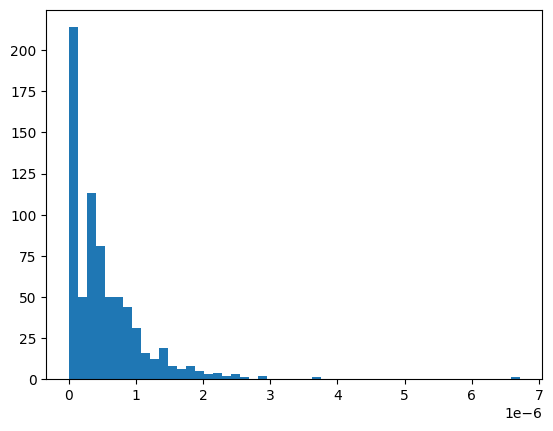

In [515]:
plt.hist(PVP_2b.get_avg_speed(), bins = 50)
print(PVP_2b.compute_diffusionAll())

In [516]:
final_displacements_squared = []
for particle_id in range(PVP_2.particleNumber):
    particle_data = PVP_2.pull_particle(particle_id)
    last_displacement_squared = particle_data['TotalDisplacementSquared'].iloc[-1]
    final_displacements_squared.append(last_displacement_squared)

times = []
for particle_id in range(PVP_2.particleNumber):
    particle_data = PVP_2.pull_particle(particle_id)
    total_time = np.sum(particle_data['dt'])
    times.append(total_time)

final_displacements_squared = np.array(final_displacements_squared)
print(final_displacements_squared)
times_1 = np.array(times)
print(times_1)
average_time_1 = np.mean(times)
print(average_time_1)

[4.00000000e-12 2.25000000e-12 0.00000000e+00 4.22500000e-13
 8.12500000e-13 1.00000000e-12 1.62500000e-12 2.50000000e-13
 2.25000000e-12 2.65625000e-13 2.81250000e-12 2.31250000e-12
 0.00000000e+00 6.25000000e-13 3.12500000e-13 1.06250000e-12
 0.00000000e+00 4.70864380e-13 0.00000000e+00 5.31581804e-14
 2.25000000e-12 5.62500000e-13 1.25000000e-12 1.81250000e-12
 1.00000000e-12 0.00000000e+00 3.12500000e-13 2.00000000e-12
 0.00000000e+00 2.26562500e-12 6.42500000e-11 0.00000000e+00
 2.50000000e-13 5.31250000e-12 2.50000000e-13 8.12500000e-13
 3.12500000e-13 0.00000000e+00 1.00000000e-12 1.25000000e-12
 3.12500000e-13 7.22500000e-13 6.25000000e-13 3.21384741e-12
 0.00000000e+00 1.29132231e-14 1.00000000e-12 3.31250000e-12
 6.25000000e-14 1.36680018e-14 0.00000000e+00 0.00000000e+00
 3.12500000e-13 5.62500000e-13 1.25000000e-13 0.00000000e+00
 5.00000000e-13 1.06250000e-12 1.29132231e-14 1.25000000e-12
 5.00000000e-13 2.25000000e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.500000

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/3660546746.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')


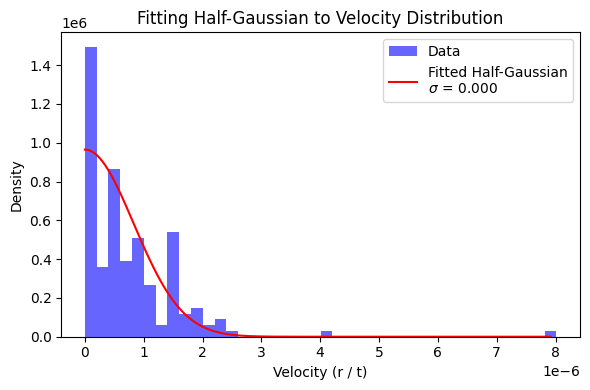

Fitted sigma: 8.272648515508385e-07


In [517]:
hist, bin_edges = np.histogram(final_displacements_squared**.5, bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit using curve_fit
popt, _ = curve_fit(half_gaussian, bin_centers, hist, p0=[1])
sigma = popt[0]

# Generate x-values and compute fitted curve
x_vals = np.linspace(0, np.max(bin_centers), 1000)
fitted_curve = half_gaussian(x_vals, sigma)

# Plot histogram and fit
plt.figure(figsize=(6, 4))
plt.hist(final_displacements_squared**.5, bins=40, density=True, alpha=0.6, color='b', label='Data')
plt.plot(x_vals, fitted_curve, 'r-', label=f'Fitted Half-Gaussian\n$\sigma$ = {sigma:.3f}')
plt.xlabel("Velocity (r / t)")
plt.ylabel("Density")
plt.legend()
plt.title("Fitting Half-Gaussian to Velocity Distribution")
plt.tight_layout()
plt.show()

# Output the sigma
print("Fitted sigma:", sigma)


In [518]:
#Sigma = 8.272648515508385e-07
#Average_time = 1.4968143371257485 s
DC_second_way = (8.272648515508385e-07**(2))/(4*1.4968143371257485)
print(DC_second_way)

1.1430394499119777e-13


In [522]:
# Error propagation 
std_dev = np.std(times_1, ddof=1)  # use ddof=1 for sample standard deviation
sem = std_dev / np.sqrt(len(times_1)) # = 0.04198326519142352

print(sem)
print(1.1430394499119777e-13* np.sqrt((0.04198326519142352 / 1.4968143371257485)**2)) #= np.float64(3.2060441405220097e-15)
print(f"Relative error: {3.2060441405220097e-15/1.1430394499119777e-13*100}") #= 2.804841198410867 %

0.04198326519142352
3.2060441405220097e-15
Relative error: 2.804841198410867


In [523]:
# bigparticle_1 = BMC_data('SJ_bigparticle_2_40x.txt')
# bigparticle_2 = BMC_data('SJ_bigparticle_3_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)


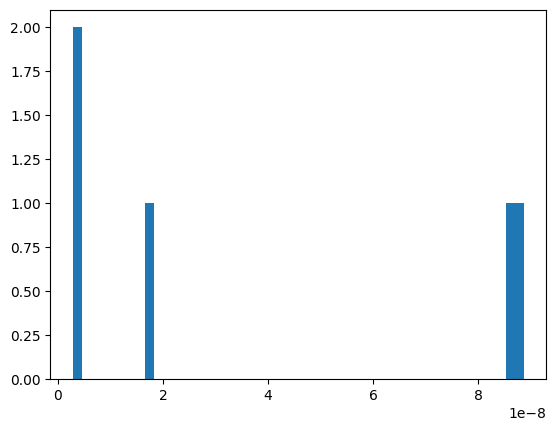

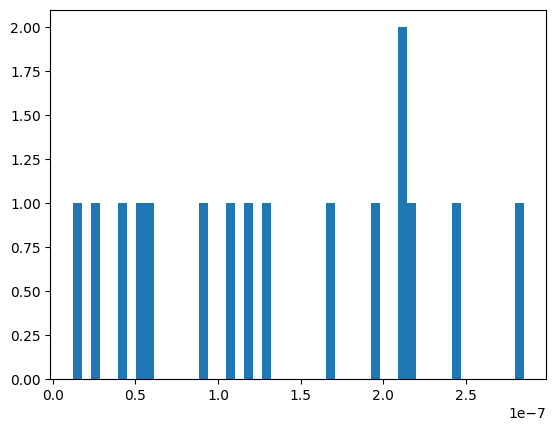

In [525]:
plt.hist(bigparticle_1.get_avg_speed(), bins = 50)
plt.show()
plt.hist(bigparticle_2.get_avg_speed(), bins = 50)
plt.show()

In [527]:
bigparticle_1 = BMC_data('SJtrial_1visco_2_particle2_40x.txt')
bigparticle_2 = BMC_data('SJtrial_2visco_2_particle2_40x.txt')
bigparticle_3 = BMC_data('SJtrial_3visco_2_particle2_40x.txt')
bigparticle_5 = BMC_data('SJtrial_5visco_2_particle2_40x.txt')

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.table = pd.read_table(BMC_file,delim_whitespace=True)
/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1552/1091848147.py:159: FutureWarning: The 'delim_whitespace' keyword in pd.r

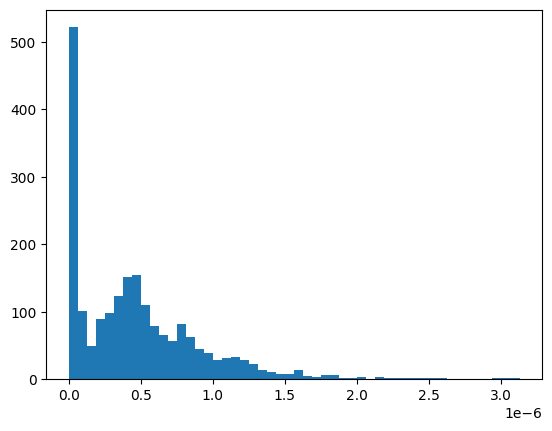

np.float64(1.0568109955955259e-13)

In [531]:
plt.hist(bigparticle_1.get_avg_speed(), bins = 50)
plt.show()
bigparticle_1.compute_diffusionAll()

In [539]:
DC_data = [6.24218932309846E-14, 1.13509948801475E-13 , 1.56228691734862E-13, 1.29527272568917E-13] 
eta_inverse = [0.3491343457, 0.6561130611, 0.4868995879, 0.4868995879]

In [540]:
print(np.polyfit(eta_inverse, DC_data, 1))

[1.47323926e-13 4.25317234e-14]
